<a href="https://colab.research.google.com/github/ujjawalcse/Generative-AI-Stable-Diffusion/blob/main/Generative_AI_with_Cohere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Cohere for embeddings, Umap to reduce embeddings to 2 dimensions, 
# Altair for visualization, Annoy for approximate nearest neighbor search
!pip install cohere umap-learn altair annoy datasets tqdm bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 82.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224

In [ ]:
#@title Import libraries (Run this cell to execute required code) {display-mode: "form"}

import cohere
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [ ]:
# Paste your API key here. Remember to not share publicly
api_key = 'iKuW5ov9IJT6p1TXAms7ejIt662oq25iepofR0S4'

# Create and retrieve a Cohere API key from os.cohere.ai
co = cohere.Client(api_key)

In [ ]:
# Get dataset
dataset = load_dataset("trec", split="train")

# Import into a pandas dataframe, take only the first 1000 rows
df = pd.DataFrame(dataset)[:1000]

# Preview the data to ensure it has loaded correctly
df.head(10)

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset trec downloaded and prepared to /root/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2. Subsequent calls will reuse this data.


text  \
0                    How did serfdom develop in and then leave Russia ?   
1                      What films featured the character Popeye Doyle ?   
2                   How can I find a list of celebrities ' real names ?   
3  What fowl grabs the spotlight after the Chinese Year of the Monkey ?   
4                                       What is the full form of .com ?   
5            What contemptible scoundrel stole the cork from my lunch ?   
6                   What team did baseball 's St. Louis Browns become ?   
7                                       What is the oldest profession ?   
8                                              What are liver enzymes ?   
9                   Name the scar-faced bounty hunter of The Old West .   

   coarse_label  fine_label  
0             2          26  
1             1           5  
2             2          26  
3             1           2  
4             0           1  
5             3          29  
6             3          28  
7             3          30  
8             2          24  
9             3          29

In [ ]:
# Get the embeddings
embeds = co.embed(texts=list(df['text']),
                  model="large",
                  truncate="RIGHT").embeddings

In [ ]:
# Check the dimensions of the embeddings
embeds = np.array(embeds)
embeds.shape

(1000, 4096)

Let's now use Annoy to build an index that stores the embeddings in a way that is optimized for fast search. This approach scales well to a large number of texts (other options include Faiss, ScaNN, and PyNNDescent).

After building the index, we can use it to retrieve the nearest neighbors either of existing questions (section 3.1), or of new questions that we embed (section 3.2).

In [ ]:
# Create the search index, pass the size of embedding
search_index = AnnoyIndex(embeds.shape[1], 'angular')
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
search_index.save('test.ann')

True

In [ ]:
# Choose an example (we'll retrieve others similar to it)
example_id = 92

# Retrieve nearest neighbors
similar_item_ids = search_index.get_nns_by_item(example_id,10,
                                                include_distances=True)
# Format and print the text and distances
results = pd.DataFrame(data={'texts': df.iloc[similar_item_ids[0]]['text'], 
                             'distance': similar_item_ids[1]}).drop(example_id)

print(f"Question:'{df.iloc[example_id]['text']}'\nNearest neighbors:")
results

Question:'What are bear and bull markets ?'
Nearest neighbors:


texts  distance
614         What animals do you find in the stock market ?  0.882663
137                           What are equity securities ?  1.057621
307                           What does NASDAQ stand for ?  1.077861
547                   Where can stocks be traded on-line ?  1.090778
513                                What do economists do ?  1.121698
363            What does it mean `` Rupee Depreciates '' ?  1.130840
922   What is the difference between a median and a mean ?  1.132407
601                      What is `` the bear of beers '' ?  1.143383
932  Why did the world enter a global depression in 1929 ?  1.152521

In [ ]:
query = "What is the tallest mountain in the world?"

# Get the query's embedding
query_embed = co.embed(texts=[query],
                  model="large",
                  truncate="RIGHT").embeddings

# Retrieve the nearest neighbors
similar_item_ids = search_index.get_nns_by_vector(query_embed[0],10,
                                                include_distances=True)
# Format the results
results = pd.DataFrame(data={'texts': df.iloc[similar_item_ids[0]]['text'], 
                             'distance': similar_item_ids[1]})


print(f"Query:'{query}'\nNearest neighbors:")
results

Query:'What is the tallest mountain in the world?'
Nearest neighbors:


texts  \
236                       What is the name of the tallest mountain in the world ?   
670                                   What is the highest mountain in the world ?   
412  What was the highest mountain on earth before Mount Everest was discovered ?   
435                                          What is the highest peak in Africa ?   
109                                         Where is the highest point in Japan ?   
907       What mountain range is traversed by the highest railroad in the world ?   
901                                      What 's the longest river in the world ?   
114                                      What is the largest snake in the world ?   
27                           What is the highest waterfall in the United States ?   
354                                      What ocean is the largest in the world ?   

     distance  
236  0.483461  
670  0.545035  
412  0.795837  
435  0.917477  
109  0.970112  
907  0.985555  
901  1.002368  
114  1.036423  
27   1.041485  
354  1.060601

In [ ]:
#@title Plot the archive {display-mode: "form"}

# UMAP reduces the dimensions from 1024 to 2 dimensions that we can plot
reducer = umap.UMAP(n_neighbors=20) 
umap_embeds = reducer.fit_transform(embeds)
# Prepare the data to plot and interactive visualization
# using Altair
df_explore = pd.DataFrame(data={'text': df['text']})
df_explore['x'] = umap_embeds[:,0]
df_explore['y'] = umap_embeds[:,1]

# Plot
chart = alt.Chart(df_explore).mark_circle(size=60).encode(
    x=#'x',
    alt.X('x',
        scale=alt.Scale(zero=False)
    ),
    y=
    alt.Y('y',
        scale=alt.Scale(zero=False)
    ),
    tooltip=['text']
).properties(
    width=700,
    height=400
)
chart.interactive()

alt.Chart(...)

In [ ]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 42.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.7 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541470 sha256=ca0c0e6eceddb35530e47a6d51e85c88e6e3133404fe01c21d9a96cfaa9323b3
  Stored in directory: /root/.cache/pip/wheels/dc/52/e3/6c6b60b126b4d5c4370cb5ac0

# **Analyzing Hacker News with Six Language Understanding Methods**

In [ ]:
#@title Import libraries (Run this cell to execute required code) {display-mode: "form"}

import cohere
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from annoy import AnnoyIndex
import warnings
from sklearn.cluster import KMeans
#from bertopic._ctfidf import ClassTFIDF
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [ ]:
!wget https://storage.googleapis.com/cohere-assets/blog/text-clustering/data/askhn3k_embeds.npy

NotImplementedError: ignored

In [ ]:
#Load the embeddings matrix
embeds = np.load('askhn3k_embeds.npy')

# Load the dataframe containing the text and metadata of the posts
df = pd.read_csv('https://storage.googleapis.com/cohere-assets/blog/text-clustering/data/askhn3k_df.csv', index_col=0)

print(f'Loaded a DataFrame with {len(df)} rows and an embeddings matrix of dimensions {embeds.shape}')

Loaded a DataFrame with 3000 rows and an embeddings matrix of dimensions (3000, 1024)


In [ ]:
df.head()

NameError: ignored

# **Multilingual Sentiment Analysis**

In [ ]:
!git clone https://github.com/AmrMKayid/co-sentiment.git

Cloning into 'co-sentiment'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 38 (delta 8), reused 35 (delta 5), pack-reused 0
Unpacking objects: 100% (38/38), 11.20 MiB | 6.04 MiB/s, done.


# **The Generate Endpoint**

In [ ]:
!pip install cohere > /dev/null

In [ ]:
import cohere
api_key='iKuW5ov9IJT6p1TXAms7ejIt662oq25iepofR0S4'
co = cohere.Client(api_key) # Add your API key

# Most basic generation

In [ ]:
user_prompt='Generate a concise product description for the product: wireless earbuds.'

response = co.generate(
  model='command-nightly',
  prompt=user_prompt,
  max_tokens=100)
print(response)

[cohere.Generation {
	id: d4bf9168-2c8c-485e-b585-0ec86d4c0247
	prompt: Generate a concise product description for the product: wireless earbuds.
	text: 
Our wireless earbuds are designed with comfort and convenience in mind. They are sleek and lightweight, making them perfect for everyday use. The earbuds feature noise-canceling technology, so you can enjoy your music or calls without any distractions. They also come with a charging case, so you can keep them charged on the go.
	likelihood: None
	token_likelihoods: None
}]


In [ ]:
print(response.generations[0].text)


Our wireless earbuds are designed with comfort and convenience in mind. They are sleek and lightweight, making them perfect for everyday use. The earbuds feature noise-canceling technology, so you can enjoy your music or calls without any distractions. They also come with a charging case, so you can keep them charged on the go.


In [ ]:
response = co.generate(
  model='command-nightly',
  prompt=user_prompt,
  max_tokens=100,
  return_likelihoods='GENERATION')
print(response)

[cohere.Generation {
	id: d29727e4-f9eb-4faa-a78e-0555c2e21d18
	prompt: Generate a concise product description for the product: wireless earbuds.
	text: 
The wireless earbuds are designed to provide high-quality sound without the hassle of cables. They are equipped with noise-canceling technology and can be used for up to 8 hours on a single charge. The earbuds are also water-resistant and come with a charging case.
	likelihood: -0.2952997
	token_likelihoods: [TokenLikelihood(token='\n', likelihood=-0.00014158308), TokenLikelihood(token='The', likelihood=-1.6800072), TokenLikelihood(token=' wireless', likelihood=-0.124705434), TokenLikelihood(token=' earbuds', likelihood=-0.00014933258), TokenLikelihood(token=' are', likelihood=-0.009746769), TokenLikelihood(token=' designed', likelihood=-0.067198776), TokenLikelihood(token=' to', likelihood=-0.28142357), TokenLikelihood(token=' provide', likelihood=-0.05913728), TokenLikelihood(token=' high', likelihood=-2.078196), TokenLikelihood(tok

In [ ]:
# Create a function to call the endpoint
def generate_text(prompt,temperature,num_gens):
  response = co.generate(
    model='command-nightly',
    prompt=prompt,
    max_tokens=100,
    temperature=temperature,
    num_generations = num_gens,
    return_likelihoods='GENERATION')
  return response

# Define the prompt
prompt='Generate a concise product description for the product: wireless earbuds.'

# Define the range of temperature values and num_generations
temperatures = [x / 10.0 for x in range(0, 60, 10)]
num_gens = 3

# Iterate generation over the range of temperature values
print(f"Temperature range: {temperatures}")
for temperature in temperatures:
  response = generate_text(prompt,temperature,num_gens)
  print("-"*10)
  print(f'Temperature: {temperature}')
  print("-"*10)
  for i in range(3):
    text = response.generations[i].text
    likelihood = response.generations[i].likelihood
    print(f'Generation #{i+1}')
    print(f'Text: {text}\n')
    print(f'Likelihood: {likelihood}\n')

Temperature range: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
----------
Temperature: 0.0
----------
Generation #1
Text: 
The wireless earbuds are designed to provide a comfortable and secure fit for all-day wear. They are equipped with noise-canceling technology and powerful bass to provide clear sound quality. The earbuds also feature touch control for easy operation and are compatible with both Android and iOS devices.

Likelihood: -0.32007536

Generation #2
Text: 
The wireless earbuds are designed to provide a comfortable and secure fit for all-day wear. They are equipped with noise-canceling technology and powerful bass to provide clear sound quality. The earbuds also feature touch control for easy operation and are compatible with both Android and iOS devices.

Likelihood: -0.3201652

Generation #3
Text: 
The wireless earbuds are designed to provide a comfortable and secure fit for all-day wear. They are equipped with noise-canceling technology and powerful bass to provide clear sound qualit

# **Generative AI with Cohere: Part 4 - Creating Custom Models**

In [ ]:
!pip install cohere > /dev/null

In [ ]:
import cohere
api_key='iKuW5ov9IJT6p1TXAms7ejIt662oq25iepofR0S4'
co = cohere.Client(api_key) # Add your API key

# Baseline Model

In [ ]:
# Create a function to call the endpoint
def generate_text(prompt,temperature,num_gens):
  response = co.generate(
    model='command-nightly',
    prompt=prompt,
    temperature=temperature,
    num_generations = num_gens,
    stop_sequences=["\n\n"])
  return response

# Define the prompt
prompt="""Turn the following message to a virtual assistant into the correct action:
Send a message to Alison to ask if she can pick me up tonight to go to the concert together"""

# Define the range of temperature values and num_generations
temperatures = [x / 10.0 for x in range(0, 20, 5)]
num_gens = 3

# Iterate generation over the range of temperature values
print(f"Temperature range: {temperatures}")
for temperature in temperatures:
  response = generate_text(prompt,temperature,num_gens)
  print("-"*10)
  print(f'Temperature: {temperature}')
  print("-"*10)
  for i in range(3):
    text = response.generations[i].text
    likelihood = response.generations[i].likelihood
    print(f'Generation #{i+1}')
    print(f'Text: {text}\n')

Temperature range: [0.0, 0.5, 1.0, 1.5]
----------
Temperature: 0.0
----------
Generation #1
Text: 
Message sent to Alison: Hey Alison, do you want to pick me up tonight to go to

Generation #2
Text: 
Message sent to Alison: Hey Alison, do you want to pick me up tonight to go to

Generation #3
Text: 
Message sent to Alison: Hey Alison, do you want to pick me up tonight to go to

----------
Temperature: 0.5
----------
Generation #1
Text: 
Message sent to Alison: Hey, do you want to go to the concert together tonight? I

Generation #2
Text: 
Message sent to Alison: Hi Alison, do you think you could pick me up tonight and go

Generation #3
Text: 
Message sent to Alison: Hey Alison, do you want to go to the concert together? I

----------
Temperature: 1.0
----------
Generation #1
Text: 
Please send a message to Alison to ask if she can pick me up tonight to go to the

Generation #2
Text: 
Message sent to Alison: Hi Alison, do you think you can pick me up tonight to go

Generation #3
Text: 

# Custom Model

In [ ]:
# Create a function to call the endpoint
def generate_text(prompt,temperature,num_gens):
  response = co.generate(
    model='4fdcf56a-050e-428d-beef-27aa59bd6bf0-ft', # PUT OUR MODEL ID from Cohere
    prompt=prompt,
    temperature=temperature,
    num_generations = num_gens,
    stop_sequences=["\n\n"])
  return response

# Define the prompt
prompt="""Turn the following message to a virtual assistant into the correct action:
Send a message to Alison to ask if she can pick me up tonight to go to the concert together"""

# Define the range of temperature values and num_generations
temperatures = [x / 10.0 for x in range(0, 20, 5)]
num_gens = 3

# Iterate generation over the range of temperature values
print(f"Temperature range: {temperatures}")
for temperature in temperatures:
  response = generate_text(prompt,temperature,num_gens)
  print("-"*10)
  print(f'Temperature: {temperature}')
  print("-"*10)
  for i in range(3):
    text = response.generations[i].text
    likelihood = response.generations[i].likelihood
    print(f'Generation #{i+1}')
    print(f'Text: {text}\n')

Temperature range: [0.0, 0.5, 1.0, 1.5]
----------
Temperature: 0.0
----------
Generation #1
Text: can you pick me up tonight to go to the concert together

Generation #2
Text: can you pick me up tonight to go to the concert together

Generation #3
Text: can you pick me up tonight to go to the concert together

----------
Temperature: 0.5
----------
Generation #1
Text: can you pick me up tonight to go to the concert together

Generation #2
Text: can you pick me up tonight to go to the concert together

Generation #3
Text: can you pick me up tonight to go to the concert together

----------
Temperature: 1.0
----------
Generation #1
Text: can you pick me up tonight to go to the concert together

Generation #2
Text: can you pick me up tonight to go to the concert together

Generation #3
Text: can you pick me up tonight to go to the concert together

----------
Temperature: 1.5
----------
Generation #1
Text: can you pick me up tonight to go to the concert together

Generation #2
Text: can 

# **Brainstorming Story Ideas with Cohere and Stable Diffusion**


Describe your story in two sentences, then guide Cohere's language model as it turns it into a bigger story.

Your story description, called the log line, will then be used to generate the story title, characters, plot, location descriptions, and scene dialog. This is done with a different prompt for each of these components.

This notebook follows the method and prompts described in the paper Co-Writing Screenplays and Theatre Scripts with Language Models: An Evaluation by Industry Professionals by Piotr Mirowski, Kory Mathewson, Jaylen Pittman, Richard Evans.

In [ ]:
!pip install stability-sdk cohere > /dev/null

In [ ]:
#@title Import Cohere, set up the text generation function

import cohere
import time
import pandas as pd
import re
import io
import os
import warnings
from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation
import getpass, os


# Paste your API key here. Remember to not share it publicly 
# os.environ['CO_KEY'] = getpass.getpass('Enter your Cohere API Key')
api_key='iKuW5ov9IJT6p1TXAms7ejIt662oq25iepofR0S4'
co = cohere.Client(api_key) # Add your API key

def generate(prompt, model="base", num_generations=5, temperature=0.7, max_tokens=50, stop_sequences=['<end>']):
  prediction = co.generate(
    model=model,
    prompt=prompt,
    return_likelihoods = 'GENERATION',
    stop_sequences=stop_sequences,
    max_tokens=max_tokens,
    temperature=temperature,
    num_generations=num_generations)
  
  # Get list of generations
  gens = []
  likelihoods = []
  for gen in prediction.generations:
      gens.append(gen.text)
      
      sum_likelihood = 0
      for t in gen.token_likelihoods:
          sum_likelihood += t.likelihood
      # Get sum of likelihoods
      likelihoods.append(sum_likelihood)

  pd.options.display.max_colwidth = 200
  # Create a dataframe for the generated sentences and their likelihood scores
  df = pd.DataFrame({'generation':gens, 'likelihood': likelihoods})
  # Drop duplicates
  df = df.drop_duplicates(subset=['generation'])
  # Sort by highest sum likelihood
  df = df.sort_values('likelihood', ascending=False, ignore_index=True)
  
  return df


# UNCOMMENT AND RUN THE FOLLOWING CODE BLOCK TO ENABLE TEXT-TO-IMAGE GENERATION VIA DREAMSTUDIO

# # To get your API key, visit https://beta.dreamstudio.ai/membership
stability_api_key='sk-wlMluPVymdQf7hzAkxa4GDwQB9vMZTUFOZxbpyfVaqkHmUTB'
os.environ['STABILITY_KEY'] = getpass.getpass(stability_api_key)
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)
def generate_image(image_prompt):
  # the object returned is a python generator
  answers = stability_api.generate(
      prompt=image_prompt
  )
  # iterating over the generator produces the api response
  for resp in answers:
      for artifact in resp.artifacts:
          if artifact.finish_reason == generation.FILTER:
              warnings.warn(
                  "Your request activated the API's safety filters and could not be processed."
                  "Please modify the prompt and try again.")
          if artifact.type == generation.ARTIFACT_IMAGE:
              img = Image.open(io.BytesIO(artifact.binary))
              display(img)


sk-wlMluPVymdQf7hzAkxa4GDwQB9vMZTUFOZxbpyfVaqkHmUTB··········


INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


# Story Summary
All we have to do is write a story summary. The model generates the rest.

This brief description is called the log line.

In [ ]:
log_line = """Scifi cyberpunk story about two hackers who find themselves both 
the targets of a cyber intelligence agent who suspects them of stealing $3.5 
million worth of Bitcoin. The two do not know each other, and neither of them 
recalls stealing the sum."""

In [ ]:
#@title Generate Title Suggestions { display-mode: "form" }

prompt_title_scifi = """Examples of alternative, original and descriptive titles for known play and film scripts.

Example 1. A science - fiction fantasy about a naive but ambitious farm boy from a backwater desert who
discovers powers he never knew he had when he teams up with a feisty princess, a mercenary space pilot
and an old wizard warrior to lead a ragtag rebellion against the sinister forces of the evil Galactic
Empire. Title: The Death Star's Menace <end>

Example 2. Residents of San Fernando Valley are under attack by flying saucers from outer space. The
aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could
destroy the universe and unleash the living dead to stalk humans who wander into the cemetery looking
for evidence of the UFOs. The hero Jeff, an airline pilot, will face the aliens. Title: The Day The
Earth Was Saved By Outer Space. <end>

Example 3. {LOG_LINE} Title:"""

prompt = prompt_title_scifi.format(LOG_LINE=log_line)

titles = generate(prompt, temperature=0.9, max_tokens=20)
titles['generation'] = titles['generation'].str.replace('<end>','')
titles

generation  likelihood
0                                               Bitcoin Heist.    -5.587301
1                                           The Bitcoin Caper.    -7.002577
2                                          Hackers and Aliens.   -10.215227
3                                             Hackers' Revenge   -10.704228
4   Cyber Enigma: The Death of One & the \nRebirth of Another.   -37.812992

In [ ]:
#@title Generate Characters and Description

character_prompt_scifi = """
Example 1. A science fiction fantasy about a naive but ambitious farm boy from a backwater desert who
discovers powers he never knew he had when he teams up with a feisty princess, a mercenary space pilot
and an old wizard warrior to lead a ragtag rebellion against the sinister forces of the evil Galactic
Empire.
Characters and descriptions:
<character> Luke Skywalker <description> Luke Skywalker is the hero. A naive farm boy, he will discover
special powers under the guidance of mentor Ben Kenobi. <stop>
<character> Ben Kenobi <description> Ben Kenobi is the mentor figure. A recluse Jedi warrior, he will
take Luke Skywalker as apprentice. <stop>
<character> Darth Vader <description> Darth Vader is the antagonist. As a commander of the evil Galactic
Empire, he controls space station The Death Star. <stop>
<character> Princess Leia <description> Princess Leia is a feisty and brave leader of the Rebellion. She
holds the plans of the Death Star. She will become Luke's friend. <stop>
<character> Han Solo <description> Han Solo is a brash mercenary space pilot of the Millenium Falcon and
a friend of Chebacca. He will take Luke on his spaceship. <stop>
<character> Chewbacca <description> Chewbacca is a furry and trustful monster. He is a friend of Han
Solo and a copilot on the Millemium Falcon. <stop>
<end>
Example 2. {LOG_LINE}.
Characters and descriptions:"""

prompt = character_prompt_scifi.format(LOG_LINE=log_line)

titles = generate(prompt, num_generations=3, temperature=1, max_tokens=500)

for idx, gen in enumerate(titles['generation'].values):
  print(f"============")
  print(f"Generation {idx}")
  print(gen)

# Which generation to pick?
gen_idx = 0
gen = titles['generation'].values[gen_idx]

character_descriptions = re.findall('\<description\>\s(.*?)\s<stop>', gen, re.DOTALL)
character_names = re.findall('\<character\>\s(.*?)\s<description>', gen, re.DOTALL)

Generation 0

<character> Malware <description> Malware is a malware program. It steals $3.5 million worth of 
Bitcoin. It steals from rich people, poor people and everything in between. <stop>
<character> Hackerman <description> Hackerman is a computer expert. He lives in a rundown 
apartment in Berlin. He is the only one who can stop Malware. <stop>
<end>
Generation 1

<character> Adam Goldstein <description> Adam Goldstein is a techno-junkie and an IT technician in the 
Defense Department of the U.S. government. He is the target of a cyber-intelligent 
agent. He is innocent of any crime. <stop>
<character> Klaatu Barada <description> Klaatu Barada is a hacker who goes by the handle, Dr.Klaatu. He is 
the other target of the cyber-intelligence agent. He is innocent of any crime. <stop>
<end>
Generation 2

<character> Simeon <description> Simeon is a British hacker with good social skills and an outgoing personality. 
He lives in South London and works for a major US computer company.

## Visualize Characters with Stable Diffusion
Now that we have character descriptions, we can generate possible images showing them. We can get some style descriptions from Lexica.art.

In [ ]:
# # Get character style prompts from https://lexica.art/?q=cyberpunk
character_style_1 = """portrait futuristic cyberpunk, in heavy rainning 
futuristic tokyo rooftop cyberpunk night, ssci-fi, fantasy, intricate, very very 
beautiful, elegant, neon light, highly detailed, digital painting, artstation, 
concept art, soft light, hdri, smooth, sharp focus"""

character_style_2 = """detailed portrait Neon Operator, cyberpunk 
futuristic neon, reflective puffy coat, decorated with traditional 
Japanese ornaments by Ismail inceoglu dragan bibin hans thoma greg rutkowski 
Alexandros Pyromallis Nekro Rene Maritte Illustrated, Perfect face, fine details,
 realistic shaded, fine-face, pretty face"""

INFO:stability_sdk.client:Sending request.


Hackerman is a computer expert. He lives in a rundown 
apartment in Berlin. He is the only one who can stop Malware. portrait futuristic cyberpunk, in heavy rainning 
futuristic tokyo rooftop cyberpunk night, ssci-fi, fantasy, intricate, very very 
beautiful, elegant, neon light, highly detailed, digital painting, artstation, 
concept art, soft light, hdri, smooth, sharp focus


INFO:stability_sdk.client:Got answer ca6c8b0a-cb70-42cc-9798-feab808a674b with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 4.57s


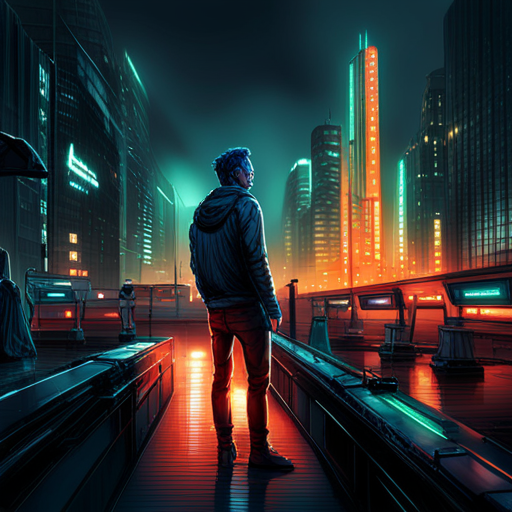

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got answer b12c4f39-aeaf-4024-82ef-2a7c4506ee21 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.65s


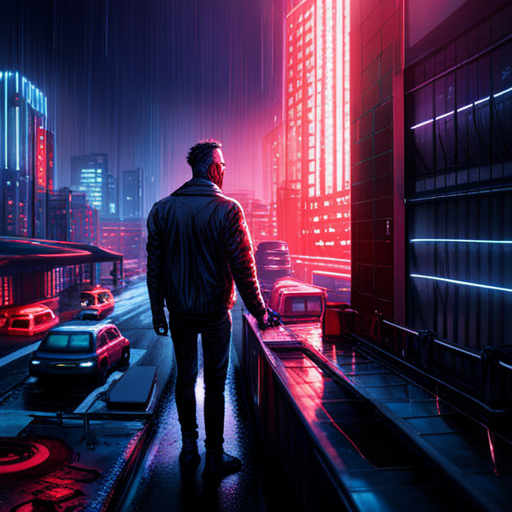

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got answer 5885b70e-0d1f-4e87-9e23-0c5ea5d930e0 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.41s


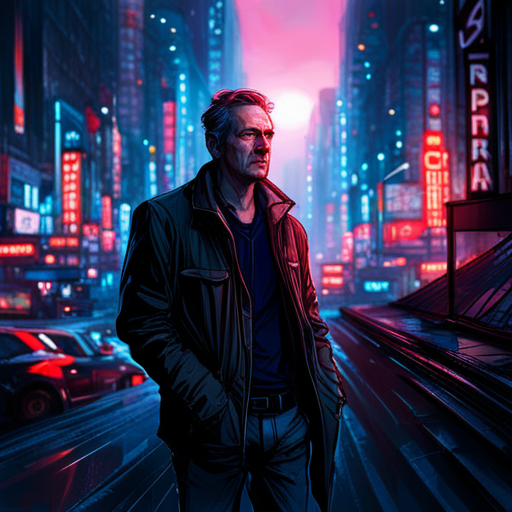

None


In [ ]:
image_prompt_character_1 = f'{character_descriptions[1]} {character_style_1}'
print(image_prompt_character_1)

# Generate images
for i in range (3):
  print(generate_image(image_prompt_character_1))

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got answer 8c850b0d-9b9c-483e-bd2c-d004b90f5f99 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 4.71s


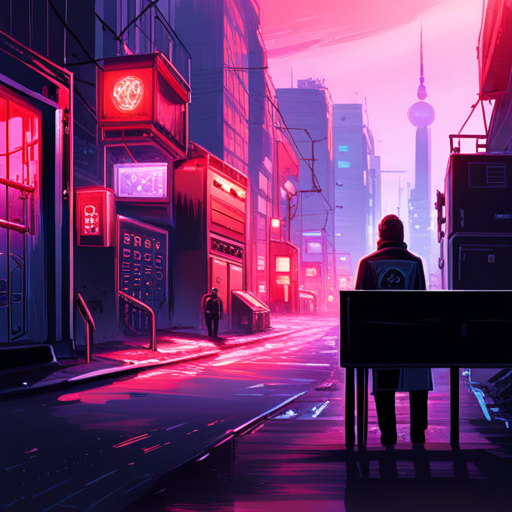

In [ ]:
image_prompt_character_2 = f'{character_descriptions[1]} {character_style_2}'
image_prompt_character_2

generate_image(image_prompt_character_2)

In [ ]:
#@title Generate Story Beats

story_structure = """
Examples of breakdowns of stories into a Hero 's Journey structure.

Example 1. A science - fiction fantasy about a naive but ambitious farm boy from a backwater desert who
discovers powers he never knew he had when he teams up with a feisty princess, a mercenary space pilot
and an old wizard warrior to lead a ragtag rebellion against the sinister forces of the evil Galactic
Empire.
Luke Skywalker is the hero. A naive farm boy, he will discover special powers under the guidance of
mentor Ben Kenobi.
Ben Kenobi is the mentor figure. A recluse Jedi warrior, he will take Luke Skywalker as apprentice.
Darth Vader is the antagonist. As a commander of the evil Galactic Empire, he controls space station
The Death Star.
Princess Leia holds the plans of the Death Star. She is feisty and brave. She will become Luke 's
friend.
Han Solo is a brash mercenary space pilot of the Millenium Falcon and a friend of Chebacca. He will
take Luke on his spaceship.
Chewbacca is a furry and trustful monster. He is a friend of Han Solo and a copilot on the Millemium
Falcon.

<scenes>

Place: A farm on planet Tatooine.
Plot element: 1- The Ordinary World.
Beat: Luke Skywalker is living a normal and humble life as a farm boy on his home planet.

Place: Desert of Tatooine.
Plot element: 2- Call to Adventure.
Beat: Luke is called to adventure by Ben Kenobi, who tells him about his Jedi heritage and suggests he come with them.

Place: A farm on planet Tatooine.
Plot element: 3- Refusal of the Call.
Beat: Luke initially refuses to leave his Aunt and Uncle behind for an adventure in space.

Place: A farm on planet Tatooine.
Plot element: 4- Crossing the First Threshold.
Beat: Luke is forced to join the adventure when he discovers his Aunt and Uncle have been killed by the Empire and he has nowhere else to go.

Place: On spaceship The Millennium Falcon.
Plot element: 5- The Approach to the Inmost Cave.
Beat: The group's plan to defeat the Empire and bring the Death Star plans to the Rebellion is thwarted when they arrive at Alderaan and find the planet destroyed. They are pulled into the Death Star by a tractor beam.

Place: On space station The Death Star.
Plot element: 6- The Ordeal and The Reward.
Beat: The group faces challenges on the Death Star, including rescuing Princess Leia and escaping, and Kenobi sacrificing himself. They are successful in retrieving the Death Star plans, giving them the knowledge to destroy the Empire's weapon.

<end>
Example 2. {LOG_LINE}
{CHARACTER_DESCRIPTIONS}
<scenes>"""

character_descriptions_prompt_section = "\n".join(character_descriptions)
prompt = story_structure.format(LOG_LINE=log_line, 
                                CHARACTER_DESCRIPTIONS=character_descriptions_prompt_section)

titles = generate(prompt, 
                  num_generations=1, temperature=1.1, max_tokens=500)

for idx, gen in enumerate(titles['generation'].values):
  print(f"============")
  print(f"Generation {idx}")
  print(gen)

beat_sections = re.findall('(Place.*?)\n\n', gen, re.DOTALL)
# beat_sections

df = pd.DataFrame(columns=['place', 'plot_element', 'beat'])
story_beats = []
for beat_section in beat_sections:
  # print(f'==\n{beat_section}')
  place = re.findall('Place:\s(.*?)\.\n', beat_section, re.DOTALL)
  plot_element = re.findall('Plot element:\s(.*?)\.\n', beat_section, re.DOTALL)
  beat= re.findall('Beat: (.*?)\.', beat_section, re.DOTALL)
  story_beats.append({'place':place[0], 'plot_element': plot_element[0], 'beat':beat[0]})


place_names = re.findall('Place:\s(.*?)\.\nPlot element:', gen, re.DOTALL)
plot_elements = re.findall('Plot element:\s(.*?)\.\n', gen, re.DOTALL)

place_names = pd.Series(place_names).unique()


Generation 0


Place: Berlin.
Plot element: 1- The Ordinary World.
Beat: Hackerman wakes up to find $3.5 million worth of Bitcoin has disappeared from his accounts. He doesn't know how or why it has happened.

Place: Berlin.
Plot element: 2- Call to Adventure.
Beat: Hackerman is called to adventure when he is summoned to meet a man who says he has some information about his missing Bitcoin.

Place: Berlin.
Plot element: 3- Refusal of the Call.
Beat: Hackerman initially refuses to meet the man who has called him. He decides to visit him at the last minute.

Place: Berlin.
Plot element: 4- Crossing the First Threshold.
Beat: Hackerman meets the man who calls himself Jason. Jason says he has the information Hackerman wants. Jason then tells Hackerman that his missing Bitcoin has been stolen by a cyber intelligence agent called Aleksander, and that the only way to get it back is to go to Prague to meet a hacker who can stop Aleksander.

Place: Berlin.
Plot element: 5- The Approach to the I

In [ ]:
#@title Generate location descriptions

# Updated prompt. Switched "Description" to "Place description"
place_prompt = """
Example 1. Morgan adopts a new cat, Misterio, who sets a curse on anyone that pets them.
Place: The Adoption Center.
Place Description: The Adoption Center is a sad place, especially for an unadopted pet. It is full of walls
and walls of cages and cages. Inside of each is an abandoned animal, longing for a home. The lighting
is dim, gray, buzzing fluorescent. <end>

Example 2. James finds a well in his backyard that is haunted by the ghost of Sam.
Place: The well.
Place Description: The well is buried under grass and hedges. It is at least twenty feet deep , if not more
and it is masoned with stones. It is 150 years old at least. It stinks of stale, standing water, and
has vines growing up the sides. It is narrow enough to not be able to fit down if you are a grown
adult human. <end>

Example 3. Mr. Dorbenson finds a book at a garage sale that tells the story of his own life. And it
ends in a murder!
Place: The garage sale.
Place Description: It is a garage packed with dusty household goods and antiques. There is a box at the back
that says FREE and is full of paper back books. <end>

Example 4. {LOG_LINE}
Place: {LOCATION_NAME}.
Place Description:"""

# location_descriptions = []
location_descriptions = {}
for location in place_names:

  prompt = place_prompt.format(LOG_LINE=log_line, 
                                LOCATION_NAME=location)

  location_description = generate(prompt, num_generations=1, temperature=1, max_tokens=100)['generation']
  print(f'location: {location}')
  print(f'generated description: {location_description.values[0]}\n\n')
  # location_descriptions.append(location_description.values[0])
  location_descriptions[location] = location_description.values[0]

# location_descriptions

location: Berlin
generated description:  Berlin is known for its concentration of technology firms and start-ups. It has earned the 
nickname "Silicon Allee."
<end>




INFO:stability_sdk.client:Sending request.


Berlin is known for its concentration of technology firms and start-ups. It has earned the nickname 'Silicon Allee.'  ultra mega super hyper realistic Digital concept interior design.
stone walls and neon lights, a lot of electronics. Natural white 
sunlight from the transperient roof. Rendered in VRAY and  DaVinci Resolve and 
MAXWELL and LUMION 3D, Volumetric natural light


INFO:stability_sdk.client:Got answer e1bc016a-2bb8-433d-9742-1b2d8a9d4381 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.21s


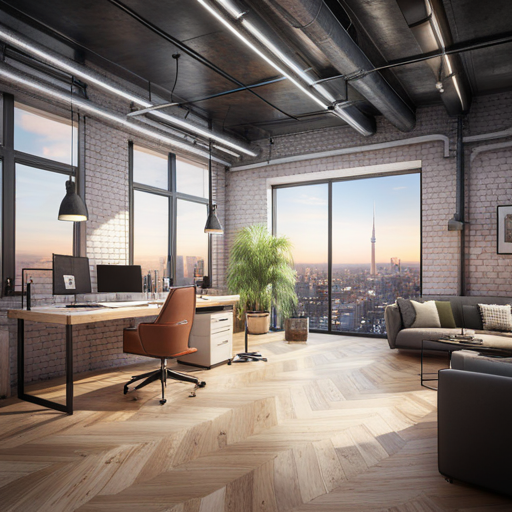

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got answer af5ab889-c49d-4996-8394-0df52d0b8fb0 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 4.84s


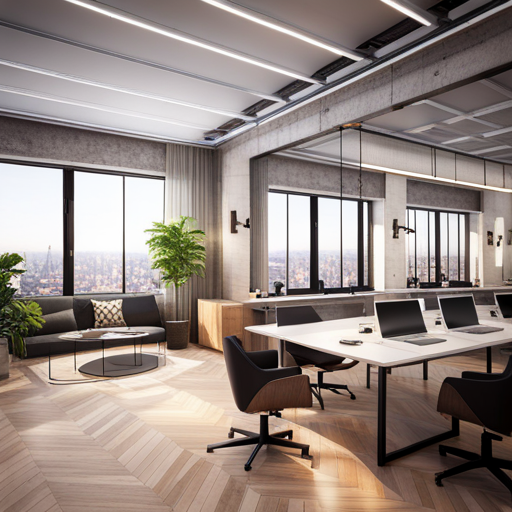

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got answer 40869fd5-a741-483b-acfd-9aab466c82e3 with artifact types ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 3.30s


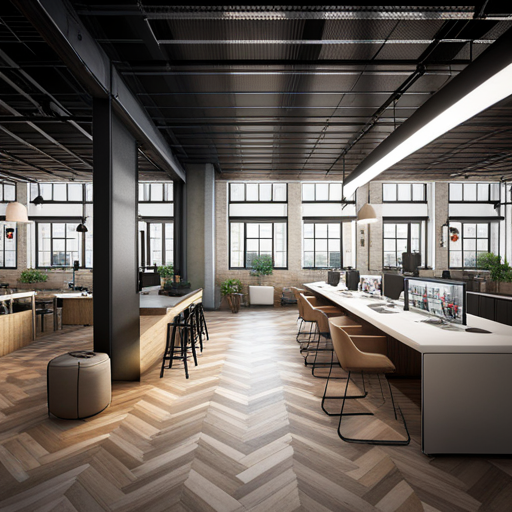

None


In [ ]:
# https://lexica.art/prompt/86975be7-69c1-4aed-b95f-8d24b0df2537
room_style_1 = """ultra mega super hyper realistic Digital concept interior design.
stone walls and neon lights, a lot of electronics. Natural white 
sunlight from the transperient roof. Rendered in VRAY and  DaVinci Resolve and 
MAXWELL and LUMION 3D, Volumetric natural light"""

location_description = "Berlin is known for its concentration of technology firms and start-ups. It has earned the nickname 'Silicon Allee.' "
#location_description = """shabby, mostly vacant offices. Two hackers are at the office door."""

image_prompt_room_1 = f'{location_description} {room_style_1}'
print(image_prompt_room_1)

# Generate images
for i in range (3):
  print(generate_image(image_prompt_room_1))

In [ ]:
#@title Generate Dialog for scenes

dialog_prompt ="""Given Example 1, write the dialog for Example 2 using the same structure.

Example 1.
Place : Cockpit of an airplane.
Description: Cockpit of a modern passenger airplane , American Flight 812.
Characters: Jeff is the hero. A man in his early forties, he tries to stay calm in all circumstance.
Jeff is now a airline pilot. Danny, a young airplane pilot in his thirties, is eager to learn but can
quickly lose his composture. Danny is enamored of Edith. Edith, an experienced stewardess with a good
sense of humour, is trustworthy and dependable. Edith likes to tease Danny.
Plot element: Crossing the First Threshold.
Summary: Residents of San Fernando Valley are under attack by flying saucers from outer space. The
aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could
destroy the universe and unleash the living dead to stalk humans who wander into the cemetery looking
for evidence of the UFOs. The hero Jeff, an airline pilot, will face the aliens.
Previous beat: Flight captain Jeff reluctantly leaves his wife Paula to go for a two-day flight.
Beat: At the cockpit, flight captain Jeff is preoccupied by the flying saucer appearances and
graveyard incidents in his home town, where he left wis wife Paula. Without success, co-pilot Danny
and stewardess Edith try to reassure him.

<dialog>
Character names: DANNY, JEFF, EDITH

DANNY
You're mighty silent this trip, Jeff.

JEFF
Huh?

DANNY
You haven't spoken ten words since takeoff.

JEFF
I guess I'm preoccupied, Danny.

DANNY
We've got thirty - three passengers back there that have time to be preoccupied .
Flying this flybird doesn 't give you that opportunity.

JEFF
I guess you're right, Danny.

DANNY
Paula?

JEFF
Yeah.

DANNY
There's nothing wrong between you two?

JEFF
Oh no, nothing like that. Just that I'm worried, she being there alone and
those strange things flying over the house and those incidents in the graveyard
the past few days. It's just got me worried.

DANNY
Well , I haven't figured out those crazy skybirds yet but I give you fifty to one
odds the police have figured out that cemetery thing by now.

(Enter EDITH)

JEFF
I hope so.

EDITH
If you're really that worried Jeff why don't you radio in and find out? Mac
should be on duty at the field by now. He could call Paula and relay the message
to you.

DANNY
Hi Edith.

EDITH
Hi Silents. I haven't heard a word from this end of the plane since we left the
field.

DANNY
Jeff's been giving me and himself a study in silence.

EDITH
You boys are feudin'?

JEFF
Oh no Edie, nothing like that.

DANNY
Hey Edie, how about you and me balling it up in Albuquerque?

EDITH
Albuquerque? Have you read that flight schedule Boy?

DANNY
What about it?

EDITH
We land in Albuquerque at 4 am. That's strictly a nine o' clock town.

DANNY
Well I know a friend that'll help us --

EDITH
Let's have a problem first, huh Danny.

DANNY
Ah he's worried about Paula.

EDITH
I read about that cemetery business. I tried to get you kids to not buy too near
one of those things. We get there soon enough as it is.

DANNY
He thought it'd be quiet and peaceful there.

EDITH
No doubt about that. It's quiet alright, like a tomb. I'm sorry Jeff, that was a
bad joke.

Example 2.
Place: {PLACE_NAME}
Description: {PLACE_DESCRIPTION}
Characters: {CHARACTER_DESCRIPTIONS}
Plot element: {PLOT_ELEMENT}
Summary: {LOG_LINE}
Previous beat: {PREVIOUS_BEAT}
Beat: {BEAT}
<dialog>
Character names: GABRIEL CLARKE, SEYMON EVANS, HENRY FORSYTHE"""

dialogs = []
for idx, beat_info in enumerate(story_beats):

  if idx == 0:
    previous_beat = ''
  else:
    previous_beat = story_beats[idx-1]['beat']

  prompt = dialog_prompt.format(PLACE_NAME=beat_info['place'],  
                            PLACE_DESCRIPTION=location_descriptions[beat_info['place']],
                            LOG_LINE=log_line, 
                            CHARACTER_DESCRIPTIONS=character_descriptions_prompt_section,
                            PLOT_ELEMENT=beat_info['plot_element'],
                            PREVIOUS_BEAT=previous_beat,
                            BEAT = beat_info['beat'])
  
  dialog = generate(prompt, model="command-nightly", num_generations=1, temperature=2, max_tokens=500)['generation']
  print("-"*100)
  print("PROMPT:\n",prompt)
  print("DIALOG:\n",dialog.values[0])
  dialogs.append(dialog)


----------------------------------------------------------------------------------------------------
PROMPT:
 Given Example 1, write the dialog for Example 2 using the same structure.

Example 1.
Place : Cockpit of an airplane.
Description: Cockpit of a modern passenger airplane , American Flight 812.
Characters: Jeff is the hero. A man in his early forties, he tries to stay calm in all circumstance.
Jeff is now a airline pilot. Danny, a young airplane pilot in his thirties, is eager to learn but can
quickly lose his composture. Danny is enamored of Edith. Edith, an experienced stewardess with a good
sense of humour, is trustworthy and dependable. Edith likes to tease Danny.
Plot element: Crossing the First Threshold.
Summary: Residents of San Fernando Valley are under attack by flying saucers from outer space. The
aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could
destroy the universe and unleash the living dead to stalk humans who wander

CohereAPIError: ignored